# Lab 3: Find SVM parameters by SGD/QP
*Author: Dr. Yiru Zhang*

*Computer Science Departement*

*Ecole Supérieure d'Ingénieur Léonard-de-Vinci*

In this lab session, you will implement SVM, a classification algorithm. Even though many well maintained toolboxes exist (such as scikit learn), you must implement this algorithms from scratch, for a better comprehension of the mathematical behind. You will build the following competences:
1. A better understanding of algorithms SVM.
2. Implementation of SGD as an optimization process.
3. Use `qpsolvers` for quadratic programming solution

This work should be done by group of **TWO students (maximum)**.


## Working on generated data
We create two sets of 80 seperable points `X1` and `X2`, then implement a linear SVM model to classify it. The first set is linarly separable, while the second is not.


In [108]:
from qpsolvers import available_solvers
print(available_solvers)


['cvxopt']


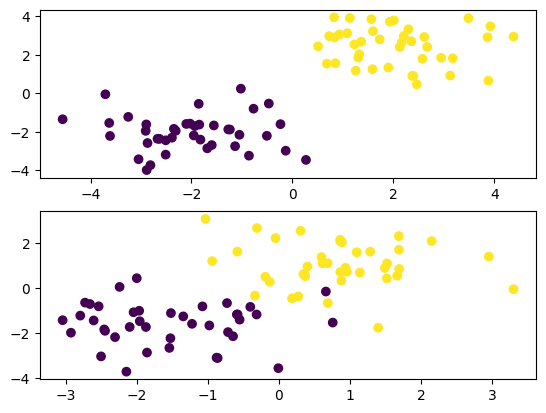

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles


np.random.seed(0)
X1 = np.r_[np.random.randn(40, 2) - [2, 2], np.random.randn(40, 2) + [2, 2]]
X2 = np.r_[np.random.randn(40, 2) - [1.5, 1.5], np.random.randn(40, 2) + [1, 1]]
Y = [0] * 40 + [1] * 40
#print(X.shape)
fig, axe = plt.subplots(2)
axe[0].scatter(X1[:, 0], X1[:, 1], c=Y)
axe[1].scatter(X2[:, 0], X2[:, 1], c=Y)
plt.show()

### A. Find parameters by Stochastic Gradient Descent
Given the training data, one general solution is mimizing loss function by gradient descent method.

Recall that a linear Soft SVM is defined as:
$$
\min_{\mathbf{w}, b} \quad \frac{1}{2} {||\mathbf{w}||}^2 +C\sum_{n=1}^N \max \{0,1- y(\mathbf{w}^T\mathbf{x} + b) \} := L
$$
where $\frac{1}{2}||\mathbf{w}||^2$ refers to L2-regularizer and C a regularization parameter (See Slide 18 in Lecture 9)

1. Implement the loss function

In [110]:
# Implement hinge loss function L
def loss(X,Y,C,w,b):
    regularizer = 0.5 * np.dot(w, w)  # (1/2) * ||w||^2

    hinge_loss = np.maximum(0, 1 - Y * (np.dot(X, w) + b)) # max(0, 1 - y * (w^T * x + b))
    error_term = C * np.sum(hinge_loss)
    
    loss = regularizer + error_term
    return loss

2. Implement the gradient
By defining the hinge loss, original optimization problem is converted to a new optimization problem without constraint. Therefore, Gradient descent algorithm can be directly applied to solve it.

#### Answer the following questions, then implement

What is the gradient of the Soft SVM loss function $\nabla L$? Give your answer of $\nabla_wL$ and $\nabla_bL$
(The derivatives are conditional, imposed by $\max \{0,1- y(\mathbf{w}^T\mathbf{x} + b) \}$)


#### Your answer here

1. **Gradient w.r.t. weights (\( \nabla_w L \)):**
$$
\nabla_wL = w - C \cdot y \cdot x, \quad \text{if } 1 - y \cdot (w^T x + b) > 0
$$
$$
\nabla_w L = w, \quad \text{otherwise.}
$$

2. **Gradient w.r.t. bias (\( \nabla_b L \)):**
$$
\nabla_bL = -C \cdot y, \quad \text{if } 1 - y \cdot (w^T x + b) > 0
$$
$$
\nabla_b L = 0, \quad \text{otherwise.}
$$

Then implement:


In [111]:
# Implement the method corresponding to your answer
def derivative_loss(xi, yi, C, w, b):
    """
    Parameters:
    ------------
    xi : (d,) array, a data sample
    yi : int, label of xi
    C : float, slackness for error term
    w : (d,) array, weight vector
    b : float, bias term

    Return:
    -------------
    d_w : (d,) array, gradient w.r.t. w
    d_b : float, gradient w.r.t. b
    """
    condition = 1 - yi * (np.dot(w, xi) + b)

    # Gradients
    if condition > 0:
        d_w = w - C * yi * xi
        d_b = -C * yi
    else:
        d_w = w
        d_b = 0

    return d_w, d_b

3. implement the learning method

Now you should implement the fitting method, with learning rate $lr$. To remind, the algorithm of SGD is described as follows:
1. Initialize the parameters (w and b, you can initialize them by 1)
2. For every `epoch` in the range of `n_epoch`:
     * iterate on each data sample
     * calculate the derivatives and loss
     * update parameters w and b by `w=w-lr*d_w`, `b=b-lr*d_b`

3. return w and b


In [112]:
# Implement the fitting method with stochastic gradient descent
def fit_SGD(X, Y, C, lr, max_iter):
    """
    Parameters:
    ----------
    X : (n_samples, n_features) ndarray
        The input data matrix.
    Y : (n_samples,) ndarray
        The corresponding labels (+1 or -1).
    C : float
        The regularization parameter controlling the penalty for margin violations.
    lr : float
        The learning rate for the gradient descent updates.
    max_iter : int
        The number of iterations (epochs) to run the SGD algorithm.

    Returns:
    ----------
    w : (n_features,) ndarray
        The optimized weight vector.
    b : float
        The optimized bias term.
    """
    # Initialize parameters
    n_samples, n_features = X.shape
    w = np.ones(n_features)  # Initialize weights to 1
    b = 1.0  # Initialize bias to 1

    # SGD loop over epochs
    for epoch in range(max_iter):
        for i in range(n_samples):
            xi = X[i]  # Select a single sample
            yi = Y[i]  # Corresponding label
            # Compute gradients using the derivative_loss function
            d_w, d_b = derivative_loss(xi, yi, C, w, b)
            # Update parameters
            w = w - lr * d_w
            b = b - lr * d_b

    return w, b


4. Implement the prediction method

Prediction is simple. Since SVM is binary classifier, you just need to see which side of the hyper plane does a data sample fall on.

You can use `np.sign()` to get the sign of each element in a matrix.


In [113]:
def predict(X, w, b):
    """
    Parameters:
    ----------
    X : (n_samples, n_features) ndarray
        The input data matrix.
    w : (n_features,) ndarray
        The trained weight vector.
    b : float
        The trained bias term.

    Returns:
    ----------
    predictions : (n_samples,) ndarray
        The predicted labels for each sample in X (-1 or +1).
    """
    # Compute the decision values
    decision = np.dot(X, w) + b
    # Return the predicted labels as the sign of the decision values
    predictions = np.sign(decision)
    return predictions


5. Testing on generated data


We are not using conventional evlauation method for classfication, but a more demonstrative method adaptive to our two-dimentional data: Just plot the hyperplane (the line) separating the two classes, with `w` and `b`



In [114]:
def plot_decision_boundary(X, Y, w, b):
    """
    Plot the hyperplane (decision boundary) for the trained SVM on 2D data.

    Parameters:
    ----------
    X : (n_samples, 2) ndarray
        The input data matrix (2D features).
    Y : (n_samples,) ndarray
        The corresponding labels (+1 or -1).
    w : (2,) ndarray
        The trained weight vector.
    b : float
        The trained bias term.
    """
    # Plot the data points
    plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Class +1')
    plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Class -1')

    # Plot the decision boundary (hyperplane)
    x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)  # Range of x1 values
    x2 = -(w[0] * x1 + b) / w[1]  # Calculate x2 values based on the decision boundary equation
    plt.plot(x1, x2, color='green', label='Decision Boundary')

    # Add labels and legend
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('SVM Decision Boundary')
    plt.show()


6. Rewrite your SVM in a python class, with file name `SVM.py`

Just as previous lab session, you need to create a SVM class with parameters `w, b, C, lr, max_iter` as class attributes (with `self`), and methods `_loss()` and  `_derivatie_loss()` as protected methods.
Then, test your code with generated data.

### B. Find Parameters by Quadratic Programming (QP)

During the course, we have learned that

A QP problem is defined as:

$$\begin{array}{cl}\underset{x}{\operatorname{minimize}} & \frac{1}{2} x^T P x+q^T x \\ \text { subject to } & G x \leq h \\ & A x=b \\ & l b \leq x \leq u b\end{array}$$




The Lagrangian dual problem of Soft SVM is described by:

$$
\begin{array}
{cl}\underset{\alpha} {\operatorname{minimize}} & \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N y_i y_j \alpha_i \alpha_j
⟨{x_i},{x_j}⟩ + \sum_{i=1}^N \alpha_i \cr
\text{subject to} \quad& \sum_{i=1}^N y_i \alpha_i =0, \quad 0 \le \alpha_i \le C, \ \forall i=1, \ldots, N
\end{array}
$$

Attention: in this equation, the variables are $\alpha$. The data $x$ are known values and are used for training process.
The dual function can be therefore rewritten as
$$
\frac{1}{2} \mathbf{𝛂 H 𝛂}^T
 + \mathbf{1}^T \cdot \mathbf{𝛂}
$$
where $\mathbf{H} = y_iy_j⟨{x_i},{x_j}⟩$

Exercise:
1. Assign the correct values to matrix $P, q, G, h, A, b, lb, ub$. Then use qpsolvers to find optimal $\mathbf{𝛂}$.

Read [the manuel of qpsovlers](https://pypi.org/project/qpsolvers/) for more utilisation of this toolbox. `qpsolvers` is not provided by Google Colab by default. If you are using Colab, you need to install it by the following command in a code block.
```
!pip install qpsolvers
```



In [115]:
from qpsolvers import solve_qp

def solve_alpha(X, Y, C):
    """
    Solve for alpha using quadratic programming.

    Parameters:
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data.
    Y : ndarray of shape (n_samples,)
        Labels (+1 or -1).
    C : float
        Regularization parameter.

    Returns:
    ----------
    alpha : ndarray of shape (n_samples,)
        Optimal Lagrange multipliers.
    """
    # Number of samples
    n_samples = X.shape[0]

    # Compute H (H_ij = y_i * y_j * <x_i, x_j>)
    H = np.outer(Y, Y) * np.dot(X, X.T)

    # Define parameters for the QP solver
    P = H
    q = -np.ones(n_samples)  # Linear term
    G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))  # Inequality constraints
    h = np.hstack((np.zeros(n_samples), C * np.ones(n_samples)))  # Inequality bounds
    A = Y.reshape(1, -1)  # Equality constraint
    b = np.array([0.0])  # Equality constraint bound

    # Solve the QP problem
    alpha = solve_qp(P, q, G, h, A, b, solver='cvxopt')
    return alpha


Once the values of $𝛂$ is found, you can calulate the parameters $\mathbf{w}$ and $\mathbf{b}$ in the SVM.
Calculate $\mathbf{w}$ from equation D1 in Slide 21 of Lecture 9:
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n y_n \mathbf{x}_n
$$
Then, the bias $b$ is calculated by:
$$
b=(1/N)\sum_{i=1}^N(y_i-\sum_{j=1}^Na_jy_jx_j^Tx_i)
$$

2. Implement the fitting method by QP solver `fit_QP()` in your SVM class.
Then test your code with generated data. You can also integrate this method in the SVM class.

In [116]:
def fit_QP(X, Y, C):
    """
    Parameters:
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data.
    Y : ndarray of shape (n_samples,)
        Labels (+1 or -1).
    C : float
        Regularization parameter.

    Returns:
    ----------
    w : ndarray of shape (n_features,)
        Weight vector.
    b : float
        Bias term.
    """
    # Solve for alpha using the QP solver
    alpha = solve_alpha(X, Y, C)

    # Calculate w (weights)
    w = np.sum((alpha * Y)[:, None] * X, axis=0)

    # Support vectors are where alpha > 0
    support_vector_indices = np.where((alpha > 1e-6) & (alpha < C))[0]
    if len(support_vector_indices) == 0:
        raise ValueError("No support vectors found; try adjusting C or the dataset.")

    # Calculate b (bias)
    b = 0
    for i in support_vector_indices:
        b += Y[i] - np.dot(w, X[i])
    b /= len(support_vector_indices)

    return w, b


3. Again, plot the fitted hyperplane with the data, with learned `w` and `b`.

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
from cvxopt import matrix

def fit_QP(X, Y, C):
    """
    Fit the SVM using the QP solver to find the optimal parameters w and b.

    Parameters:
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data.
    Y : ndarray of shape (n_samples,)
        Labels (+1 or -1).
    C : float
        Regularization parameter.

    Returns:
    ----------
    w : ndarray of shape (n_features,)
        Weight vector.
    b : float
        Bias term.
    """
    n_samples, n_features = X.shape

    # Compute H (Kernel matrix for linear SVM)
    H = np.outer(Y, Y) * np.dot(X, X.T)

    # Convert matrices to cvxopt format with the correct type
    P = matrix(H)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))
    A = matrix(Y.reshape(1, -1).astype('double'))
    b = matrix(np.array([0.0]))

    # Solve the QP problem
    alpha = np.array(solve_qp(P, q, G, h, A, b, solver='cvxopt'))

    # Compute weight vector w
    w = np.sum((alpha * Y)[:, None] * X, axis=0)

    # Support vectors
    sv_indices = np.where((alpha > 1e-6) & (alpha < C))[0]

    # Compute bias term b
    b_value = np.mean([Y[i] - np.dot(w, X[i]) for i in sv_indices])

    return w, b_value

def plot_fitted_hyperplane(X, Y, w, b):
    """
    Plot the fitted hyperplane with the data, using the learned w and b.

    Parameters:
    ----------
    X : ndarray of shape (n_samples, 2)
        The input data matrix (2D features only).
    Y : ndarray of shape (n_samples,)
        The corresponding labels (+1 or -1).
    w : ndarray of shape (2,)
        The learned weight vector.
    b : float
        The learned bias term.
    """
    # Plot the data points
    plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Class +1')
    plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Class -1')

    # Plot the decision boundary
    x1 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)  # X-axis range
    x2 = -(w[0] * x1 + b) / w[1]  # Decision boundary equation
    plt.plot(x1, x2, color='green', label='Hyperplane (Decision Boundary)')

    # Add labels, legend, and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('SVM Fitted Hyperplane')
    plt.show()

# Simulate data (replace with your dataset)
X = np.random.randn(100, 2)  # Replace with your dataset
Y = np.where(X[:, 0] + X[:, 1] > 0, 1, -1)  # Simulated labels
C = 1.0

# Fit the SVM using the fit_QP function
w, b = fit_QP(X, Y, C)

# Plot the results
plot_fitted_hyperplane(X, Y, w, b)


AttributeError: 'cvxopt.base.matrix' object has no attribute 'ndim'